# Notebook for Creating Figures from OpenFOAM Solutions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv

## Define Helper Files

In [ ]:
def camera_settings(VIEW='pylon'):
    """ Define settings for viewing the figures """
    if VIEW == 'pylon':
        camera = pv.Camera()
        camera.position = (15.9143, 3.83627, 28.3582)
        camera.focal_point = (15.9143, 3.83627, 13.75)
        camera.view_angle = 30
    elif VIEW == 'wing':
        camera = pv.Camera()
        camera.position = (6.754050981213595, 2.974053164557754, 13.524279730513474)
        camera.focal_point = (14.999999523162842, 2.974053164557754, 13.524279730513474)
        camera.view_angle = 30
    else:
        camera = pv.Camera()
        camera.position = (14.200957354542979, 0.9359974688819834, 55.47461841512844)
        camera.focal_point = (14.200957354542979, 0.9359974688819834, 1.702326812846877e-08)
        camera.view_angle = 30
    
    return camera

In [3]:
def slice_center(mesh, NORMAL='z', ORIGIN=[0, 0, 0], translate=False, CONTOUR=False):
    """Slice mesh through center in normal direction, move to zero normal."""
    slice_mesh = mesh.slice(normal=NORMAL, origin=ORIGIN, contour=CONTOUR)
    if translate is not False:
        if NORMAL == 'z':
            slice_mesh.translate((0, 0, -slice_mesh.center[-1]), inplace=True)
        elif NORMAL == 'x':
            slice_mesh.translate((-slice.mesh.center[0], 0, 0), inplace=True)
        elif NORMAL == 'y':
            slice_mesh.translate((0, -slice.mesh.center[1], 0), inplace=True)
        else:
            print('ERROR: Normal not found - ', NORMAL)
            slice_mesh = None
    return slice_mesh

In [4]:
def read_mesh(nfile):
    """ Read the OpenFOAM solution, needs the file generated by paraFoam (e.g. *.OpenFOAM) """
    # Read the reference file created by openFOAM `parafoam`
    reader = pv.POpenFOAMReader(nfile)
    # set the active time 
    reader.set_active_time_value(reader.time_values[-1])
    reader.cell_to_point_creation = True
    # Define the mesh
    mesh = reader.read()
    # Define the internal mesh and boundaries
    internal = mesh["internalMesh"]
    boundaries = mesh["boundary"]
    
    return internal, boundaries

In [5]:
def sample_line(mesh, pointA, pointB, field=None):
    """ Sample fields across a line, marked by two points, within the mesh """
    # Sample across the mesh designated by inputed points
    line = mesh.sample_over_line(pointA,
                                 pointB,
                                 resolution=100,
                                 tolerance=0.2,
                                 )
    # Define the distance of this line
    distance = line['Distance']
    
    # Check to see if a desired field to extract
    if field is not None:
        subset = line.get_array(field)
    else:
        subset = None
    
    if field is not None:
        return distance, subset
    else:
        return distance, line

In [ ]:
def plot_field(ndir, 
               nfile,
               FIELD='U', 
               RANGE=[95, 145], 
               CONTOUR=True, 
               ORIGIN=[0, 0, 0], 
               NORMAL='z', 
               CMAP='bwr',
               SAVE=False,
               VIEW='pylon',
               LINE=False):
    """ 
    Create 2-D Figure of the OpenFOAM internal mesh for selected field. 
    Normal decides which plane to exclude from display.
    Origin moves where the slice is preformed.
    """
    # add extension to the input directory file to reference *.OpenFOAM files
    solution = ndir + nfile['filename'] + nfile['filename'][:-1] + '.OpenFoam'
    
    # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [C]"
            }
    
    # Read the Mesh
    internal, boundaries = read_mesh(solution)
    
    # Slice the Mesh
    if VIEW == 'pylon':
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=nfile['pylon'])
    else:
        # fuselage
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=ORIGIN)
    
    # Contour the Mesh
    contours = p3_slice.contour(scalars=FIELD, isosurfaces=15, rng=RANGE)
    
    # Set a custom position and size
    sargs = dict(height=0.10, 
                 vertical=False, 
                 position_x=0.2, 
                 position_y=0.05, 
                 fmt="%.0f", 
                 color='black', 
                 n_labels=6, 
                 title=LABEL[FIELD])
    
    # Create the plotter
    pt = pv.Plotter()
    # Add the slice mesh
    pt.add_mesh(p3_slice, 
                scalars=FIELD, 
                preference='point', 
                cmap=CMAP, 
                clim=RANGE,
                scalar_bar_args=sargs)
    
    # Add the contours
    pt.add_mesh(contours, 
                color='white', 
                preference='cell', 
                line_width=1)
    
    # Add a ruler
    if VIEW == 'pylon':
        pt.add_ruler(pointa=[10, -0.35, 0.0],
                     pointb=[20, -0.35, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
    elif VIEW == 'wing':
        pt.add_ruler(pointa=[15, 2.5, 11.5],
             pointb=[15, 2.5, 15.5],
             title='Distance [m]',
             tick_color='black',
             label_color='black'
            )
    else:
        # fuselage view
        pt.add_ruler(pointa=[-5, -2.5, 0.0],
                     pointb=[35, -2.5, 0.0],
                     title='Distance [m]',
                     tick_color='black',
                     label_color='black'
                    )
   
    # Add a title
    pt.add_title(nfile['filename'][:-1], 
                 font='courier', 
                 color='k', 
                 font_size=10
                )
    
    # Define the camera view
    pt.camera = camera_settings(VIEW=VIEW)
    
    # Save the figure
    if SAVE is True:
        if VIEW == 'pylon':
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_PYLON_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        elif VIEW == 'wing':
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_WING_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        else:
            # fuselage
            # Define a figure title
            nout = '/Users/jrobrien/dev/dissertation/figures/' + nfile['filename'][:-1] + '_FUSELAGE_' + str(FIELD) + '.svg'
            # Save the figure
            pt.save_graphic(nout, raster=True)
        
    if LINE is True:
        # Make two points to construct the line between
        A = [13.5, nfile['pylon'][1], nfile['pylon'][2]]
        B = [14.49, nfile['pylon'][1], nfile['pylon'][2]]

        # Preview how this line intersects this mesh
        line = pv.Line(A, B)
        pt.add_mesh(line, color="white", line_width=10)
        
    # Display the figure
    pt.show()
    
    # Free up some memory
    del internal, p3_slice, contours, boundaries, pt

 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLShader'.
 JS Error => error: Uncaught TypeError: Failed to execute 'shaderSource' on 'WebGL2RenderingContext': parameter 1 is not of type 'WebGLS

In [21]:
def plot_line(ndir,
              nfiles,
              FIELD='U',
              reference=False,
              NORMAL='z',
              ORIGIN=[0,0,0],
              SAVE=True,
              **kwargs):
    """
    Create line plot for selected pylon against all angles of attack and reference solutions
    
    Parameters
    ----------
    ndir = str
        Directory holding these solutions
    nfiles = dict
        Dictionary holding pylon configuration directory names, CDP location, etc
    FIELD = str
        Scalar to display
    reference = boolean, Default=False
        If True, compare solutions against No-Pylon solutions
        
    Returns
    -------
    fig - figure plotting sampled line
    """
     # Define label for input field
    LABEL = {"U" : "Velocity [m/s]",
             "p" : "Pressure [Pa]", 
             "T" : "Temperature [C]"
            }
    
    # define a blank dictionary to hold the sample over line
    solutions = {}

    for pylon in nfiles:
        # add extension to the input directory file to reference *.OpenFOAM files
        directory = ndir + pylon['filename'] + pylon['filename'][:-1] + '.OpenFoam'
    
        # Read the Mesh
        internal, boundaries = read_mesh(directory)
    
        # Slice the Mesh
        p3_slice = slice_center(internal, NORMAL=NORMAL, ORIGIN=pylon['pylon'])
            
        # Sample over line
        disx, field = sample_line(p3_slice, pylon['pylon'], pylon['end'])
        
        solutions[pylon['tag']] = {'distance' : disx,
                                   'scalar' : field
                                  }
        # clear up some memory
        del internal, boundaries, p3_slice, disx, field
        
    # if reference is set, also extract the no pylon solutions
    # COMING SOON!
    
    # Display
    fig, axarr = plt.subplots(1, 1, figsize=[12, 8])
    for case in solutions:
        if FIELD == 'U':
            axarr.plot(solutions[case]['distance']-.922, 
                       solutions[case]['scalar'].point_data['U'][:, 0], 
                       label=case + '_Ux')
            axarr.plot(solutions[case]['distance']-.922, 
                       solutions[case]['scalar'].point_data['U'][:, 1],
                       linestyle='--',
                       label=case + '_Uy')
            axarr.plot(solutions[case]['distance']-.922, 
                       solutions[case]['scalar'].point_data['U'][:, 2], 
                       linestyle='-.',
                       label=case + '_Uz')
        else:
            axarr.plot(solutions[case]['distance']-.922,
                       solutions[case]['scalar'],
                       label=case + FIELD)
    # Define some figure comments
    if FIELD == 'U':
        axarr.set_ylim([-35, 160])
    axarr.set_xlabel('Distance from Cloud Droplet Probe Sample Volume [m]')
    axarr.set_ylabel('Velocity [m/s]')
    axarr.grid(True)
    plt.legend(loc='center left')
    
    if SAVE is True:
        tmpx = [x for x in solutions]
        # Define a figure title
        nout = '/Users/jrobrien/dev/dissertation/figures/' + 'line_sample_' + tmpx[0] + '_' + str(FIELD) + '.svg'
        # Save the figure
        plt.savefig(nout)

## Define the Directory, Case Structure, Fields and Pylon Locations

In [8]:
# Define the directory hosting the solution directories
solution_dir = "/Users/jrobrien/Dissertation/data/solutions/"
# Define available solution directories
case_120 = {'navy_120_aoa0' : {'filename' : 'NASA_navyPylon_v2_tas120_aoa0_900T33/',
                               'pylon' : [13.56, 3.05, 13.75],
                               'end' : [14.49, 3.05, 13.75],
                               'tag' : 'Navy120_AoA0'
                              },
            'extend_120_aoa0' : {'filename' : 'NASA_extendedPylon_v2_tas120_aoa0_900T33/',
                                 'pylon' : [13.0, 2.725, 13.7],
                                 'end' : [13.92, 2.725, 13.7],
                                 'tag' : 'Extend120_AoA0',
                                },
            'no_120_aoa0' : {'filename' : 'NASA_noPylons_v2_tas120_aoa0_900T33/',
                             'pylon' : [0, 2.75, 13.7],
                             'tag' : 'Null120_AoA0',
                            },
            'navy_120_aoaPos4' : {'filename' : 'NASA_navyPylon_v3_tas120_aoaPos4_900T33/',
                                  'pylon' : [13.56, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'tag' : 'Navy120_AoA+4',
                                 },
            'extend_120_aoaPos4' : {'filename' : 'NASA_extendedPylon_v3_tas120_aoaPos4_900T33/',
                                    'pylon' : [13.0, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'tag' : 'Extend120_AoA+4',
                                   },
            'no_120_aoaPos4' : {'filename' : 'NASA_noPylons_v3_tas120_aoaPos4_900T33/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null120_AoA+4',
                               },
            'navy_120_aoaNeg4' : {'filename' : 'NASA_navyPylon_v3_tas120_aoaNeg4_900T33/',
                                  'pylon' : [13.56, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'tag' : 'Navy120_AoA-4',
                                 },
            'extend_120_aoaNeg4' : {'filename' : 'NASA_extendedPylon_v3_tas120_aoaNeg4_900T33/',
                                    'pylon' : [13.0, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'tag' : 'Extend120_AoA-4',
                                   },
            'no_120_aoaNeg4' : {'filename' : 'NASA_noPylons_v3_tas120_aoaNeg4_900T33/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null120_AoA-4'
                               }
           }
# Define available solution directories
case_140 = {'navy_140_aoa0' : {'filename' : 'NASA_navyPylon_v3_tas140_aoa0_800T20/',
                               'pylon' : [13.56, 3.05, 13.75],
                               'end' : [14.49, 3.05, 13.75],
                               'tag' : 'Navy140_AoA0'
                              },
            'extend_140_aoa0' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoa0_800T20/',
                                 'pylon' : [13.0, 2.725, 13.7],
                                 'end' : [13.92, 2.725, 13.7],
                                 'tag' : 'Extend140_AoA0',
                                },
            'no_140_aoa0' : {'filename' : 'NASA_noPylons_v3_tas140_aoa0_800T20/',
                             'pylon' : [0, 2.75, 13.7],
                             'tag' : 'Null140_AoA0',
                            },
            'navy_140_aoaPos4' : {'filename' : 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/',
                                  'pylon' : [13.56, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'tag' : 'Navy140_AoA+4'
                                 },
            'extend_140_aoaPos4' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/',
                                    'pylon' : [13.0, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'tag' : 'Extend140_AoA+4',
                                   },
            'no_140_aoaPos4' : {'filename' : 'NASA_noPylons_v3_tas140_aoaPos4_800T20/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null140_AoA+4',
                               },
            'navy_140_aoaNeg4' : {'filename' : 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/',
                                  'pylon' : [13.56, 3.05, 13.75],
                                  'end' : [14.49, 3.05, 13.75],
                                  'tag' : 'Navy140_AoA-4',
                                 },
            'extend_140_aoaNeg4' : {'filename' : 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/',
                                    'pylon' : [13.0, 2.725, 13.7],
                                    'end' : [13.92, 2.725, 13.7],
                                    'tag' : 'Extend140_AoA-4',
                                   },
            'no_140_aoaNeg4' : {'filename' : 'NASA_noPylons_v3_tas140_aoaNeg4_800T20/',
                                'pylon' : [0, 2.75, 13.7],
                                'tag' : 'Null140_AoA-4',
                               }
           }

In [9]:
scalar_field_120 = {'U' : {'range' : [95, 145]},
                    'T' : {'range' : [295, 318]},
                    'p' : {'range' : [89000, 91000]}
                   }
scalar_field_140 = {'U' : {'range' : [115, 165]},
                    'T' : {'range' : [281, 305]},
                    'p' : {'range' : [79000, 81000]}
                   }

## Process the OpenFOAM Solutions

### A) Process the Solutions for TAS=120 - Along Pylon

In [ ]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
        for scalar in scalar_field_120:
                print(case_120[case])
                plot_field(solution_dir, 
                           case_120[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_120[scalar]['range'], 
                           VIEW='pylon',
                           LINE=False)

### B) Process the Solutions for TAS=120 - Along Wing

In [ ]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
            for scalar in scalar_field_120:
                if case.startswith('navy_') is True:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               NORMAL='x',
                               ORIGIN=[15, 0, 0],
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='wing',
                               LINE=False)
                if case.startswith('extend_') is True:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               NORMAL='x',
                               ORIGIN=[14.5, 0, 0],
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='wing',
                               LINE=False)

### C) Process the Solutions for TAS=120 - Along Fuselage

In [10]:
# Process the selected Scalar fields
for case in case_120:
    if case.startswith('no_') is False:
            for scalar in scalar_field_120:
                    plot_field(solution_dir, 
                               case_120[case], 
                               SAVE=True, 
                               FIELD=scalar,
                               RANGE=scalar_field_120[scalar]['range'], 
                               VIEW='fuselage',
                               LINE=False)

2023-06-04 17:29:45.655 (  21.993s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:45.665 (  22.003s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:45.959 (  22.297s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:46.233 (  22.571s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x15e9bf540)
  Debug: Off
  Modified Time: 1490242
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000017c5400
    Debug: Off
    Modified Time: 1490111
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x15fd2aa60_0&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x308d122c0)
  Debug: Off
  Modified Time: 3003853
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000017c8400
    Debug: Off
    Modified Time: 3003722
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

2023-06-04 17:29:58.597 (  34.935s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:58.607 (  34.945s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:58.895 (  35.233s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:29:59.172 (  35.510s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x313108af0_1&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x15e927540)
  Debug: Off
  Modified Time: 4517067
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000017a8a00
    Debug: Off
    Modified Time: 4516936
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

2023-06-04 17:30:10.741 (  47.079s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:10.750 (  47.088s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:11.034 (  47.372s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:11.301 (  47.639s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x313152160_2&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x295aa0370)
  Debug: Off
  Modified Time: 6030551
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600001778900
    Debug: Off
    Modified Time: 6030420
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

2023-06-04 17:30:22.969 (  59.308s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:22.978 (  59.317s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:23.263 (  59.601s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:23.528 (  59.867s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x313152df0_3&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x295af4fe0)
  Debug: Off
  Modified Time: 7543409
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000175cd00
    Debug: Off
    Modified Time: 7543278
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

2023-06-04 17:30:34.971 (  71.309s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:34.980 (  71.318s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:35.263 (  71.601s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:35.524 (  71.863s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3131463a0_4&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x29295bf90)
  Debug: Off
  Modified Time: 9056738
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600001730b00
    Debug: Off
    Modified Time: 9056607
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0

2023-06-04 17:30:46.912 (  83.251s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:46.921 (  83.260s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:47.205 (  83.543s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:47.465 (  83.803s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x313146b20_5&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x163a68080)
  Debug: Off
  Modified Time: 10569738
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600001715600
    Debug: Off
    Modified Time: 10569607
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:30:59.047 (  95.385s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:59.056 (  95.394s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:59.340 (  95.678s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:30:59.596 (  95.935s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x31323e970_6&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x164663b80)
  Debug: Off
  Modified Time: 12082505
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600001709700
    Debug: Off
    Modified Time: 12082374
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:31:11.079 ( 107.417s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:11.089 ( 107.427s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:11.371 ( 107.710s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:11.640 ( 107.979s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x313284490_7&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x308dbd7f0)
  Debug: Off
  Modified Time: 13595818
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000016ee700
    Debug: Off
    Modified Time: 13595687
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:31:23.041 ( 119.380s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:23.050 ( 119.389s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:23.333 ( 119.672s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:23.598 ( 119.937s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x31323edf0_8&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x1620c6ce0)
  Debug: Off
  Modified Time: 15108932
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000016c2c00
    Debug: Off
    Modified Time: 15108801
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:31:35.228 ( 131.567s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:35.237 ( 131.576s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:35.519 ( 131.858s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:35.787 ( 132.126s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2a2fbc190_9&reconnect=auto' style='width: …

in proper camera
fuselage
vtkOpenGLCamera (0x2a8f611b0)
  Debug: Off
  Modified Time: 16621810
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000016a6900
    Debug: Off
    Modified Time: 16621679
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:31:47.214 ( 143.553s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:47.223 ( 143.562s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:47.506 ( 143.845s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:47.773 ( 144.112s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2a2fbcb80_10&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2902c5360)
  Debug: Off
  Modified Time: 18135237
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000169b000
    Debug: Off
    Modified Time: 18135106
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:31:59.183 ( 155.522s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:59.192 ( 155.531s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:59.475 ( 155.814s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:31:59.747 ( 156.086s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x29a2ca1f0_11&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2a54e24e0)
  Debug: Off
  Modified Time: 19648192
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000167ec00
    Debug: Off
    Modified Time: 19648061
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:32:11.371 ( 167.711s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:11.381 ( 167.720s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:11.665 ( 168.004s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:11.936 ( 168.275s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2a815c460_12&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2b4cd5d80)
  Debug: Off
  Modified Time: 21160952
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000165ed00
    Debug: Off
    Modified Time: 21160821
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:32:23.379 ( 179.718s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:23.388 ( 179.727s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:23.671 ( 180.010s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:23.940 ( 180.280s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x29a2ca9d0_13&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2a8fff470)
  Debug: Off
  Modified Time: 22674318
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600001633000
    Debug: Off
    Modified Time: 22674187
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:32:35.362 ( 191.701s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:35.371 ( 191.710s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:35.654 ( 191.993s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:35.931 ( 192.270s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2b24c2400_14&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x1654852e0)
  Debug: Off
  Modified Time: 24187377
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000162ba00
    Debug: Off
    Modified Time: 24187246
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:32:47.557 ( 203.896s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:47.566 ( 203.905s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:47.848 ( 204.188s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:48.120 ( 204.460s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2b24c2370_15&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2a0271af0)
  Debug: Off
  Modified Time: 25700250
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000160b600
    Debug: Off
    Modified Time: 25700119
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:32:59.605 ( 215.945s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:59.614 ( 215.954s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:32:59.896 ( 216.236s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:33:00.162 ( 216.502s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2b4bb8970_16&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x2a02799a0)
  Debug: Off
  Modified Time: 27213737
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000057f4d00
    Debug: Off
    Modified Time: 27213606
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:33:11.584 ( 227.923s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:33:11.593 ( 227.933s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:33:11.878 ( 228.218s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:33:12.147 ( 228.486s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2b23334c0_17&reconnect=auto' style='width:…

### D) Process the Solutions for TAS=140 - Pylon

In [11]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
        for scalar in scalar_field_140:
                print(case_140[case])
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='pylon',
                           LINE=False)

2023-06-04 17:33:23.800 ( 240.139s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA0'}
pylon
vtkOpenGLCamera (0x109895e80)
  Debug: Off
  Modified Time: 27511921
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000057c0b00
    Debug: Off
    Mod

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x1085131c0_18&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA0'}
pylon
vtkOpenGLCamera (0x16559f830)
  Debug: Off
  Modified Time: 27810317
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000057a4500
    Debug: Off
    Mod

2023-06-04 17:33:35.332 ( 251.672s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x15fd2aeb0_19&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA0'}
pylon
vtkOpenGLCamera (0x29cb38c90)
  Debug: Off
  Modified Time: 28108617
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005798a00
    Debug: Off
    Mod

2023-06-04 17:33:46.824 ( 263.164s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2bbb34910_20&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA0'}
pylon
vtkOpenGLCamera (0x29ca7d030)
  Debug: Off
  Modified Time: 28412576
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000577d100
    Debug: Off
    M

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2bbb34100_21&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA0'}
pylon
vtkOpenGLCamera (0x2a02fe5c0)
  Debug: Off
  Modified Time: 28716481
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005750400
    Debug: Off
    M

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2acfa9af0_22&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoa0_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA0'}
pylon
vtkOpenGLCamera (0x29e5eec30)
  Debug: Off
  Modified Time: 29020280
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005734500
    Debug: Off
    M

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2cf1aeac0_23&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}
pylon
vtkOpenGLCamera (0x29cbd0000)
  Debug: Off
  Modified Time: 29318430
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000572a800
    Debug: Off
   

2023-06-04 17:34:33.187 ( 309.527s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2cf1aea30_24&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}
pylon
vtkOpenGLCamera (0x3124c2980)
  Debug: Off
  Modified Time: 29616798
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000570e700
    Debug: Off
   

2023-06-04 17:34:44.701 ( 321.041s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2cb29e5b0_25&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA+4'}
pylon
vtkOpenGLCamera (0x31a1cddd0)
  Debug: Off
  Modified Time: 29915168
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000056e3e00
    Debug: Off
   

2023-06-04 17:34:56.167 ( 332.507s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2ebba9b80_26&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}
pylon
vtkOpenGLCamera (0x2cc5872d0)
  Debug: Off
  Modified Time: 30218818
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000056c0100
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2acfa9790_27&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}
pylon
vtkOpenGLCamera (0x32fea1530)
  Debug: Off
  Modified Time: 30522695
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000056a4a00
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2d9131cd0_28&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaPos4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA+4'}
pylon
vtkOpenGLCamera (0x2cd2c6620)
  Debug: Off
  Modified Time: 30826571
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005698700
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2d91314f0_29&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}
pylon
vtkOpenGLCamera (0x2cc5d5190)
  Debug: Off
  Modified Time: 31124697
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000567c600
    Debug: Off
   

2023-06-04 17:35:42.655 ( 378.995s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x306801820_30&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}
pylon
vtkOpenGLCamera (0x33a3c5430)
  Debug: Off
  Modified Time: 31423053
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005652000
    Debug: Off
   

2023-06-04 17:35:54.374 ( 390.714s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x306801550_31&reconnect=auto' style='width:…

{'filename': 'NASA_navyPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.56, 3.05, 13.75], 'end': [14.49, 3.05, 13.75], 'tag': 'Navy140_AoA-4'}
pylon
vtkOpenGLCamera (0x2d2c92f00)
  Debug: Off
  Modified Time: 31721443
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.6832, 15.8078)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.12466
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600005636800
    Debug: Off
   

2023-06-04 17:36:06.101 ( 402.441s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3068016d0_32&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}
pylon
vtkOpenGLCamera (0x2d1f58560)
  Debug: Off
  Modified Time: 32025073
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000562a400
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33d094070_33&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}
pylon
vtkOpenGLCamera (0x323fdfc60)
  Debug: Off
  Modified Time: 32328923
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000560c700
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33d094520_34&reconnect=auto' style='width:…

{'filename': 'NASA_extendedPylon_v3_tas140_aoaNeg4_800T20/', 'pylon': [13.0, 2.725, 13.7], 'end': [13.92, 2.725, 13.7], 'tag': 'Extend140_AoA-4'}
pylon
vtkOpenGLCamera (0x2d3c7b660)
  Debug: Off
  Modified Time: 32632824
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (13.73, 15.862)
  DirectionOfProjection: (0, 0, -1)
  Distance: 14.6082
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15.9143, 3.83627, 13.75)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (15.9143, 3.83627, 28.3582)
  Stereo: Off
  Left Eye: 1
  Thickness: 2.13193
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000097e3600
    Debug: Off
 

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x337fad5e0_35&reconnect=auto' style='width:…

### E) Process the Solutions for TAS=140 - Along wing

In [12]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
            for scalar in scalar_field_140:
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar,
                           NORMAL='x',
                           ORIGIN=[15, 0, 0],
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='wing',
                           LINE=False)

wing
vtkOpenGLCamera (0x327421790)
  Debug: Off
  Modified Time: 33822002
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000097c7d00
    Debug: Off
    Modified Time: 33821871
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:36:53.394 ( 449.735s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:36:53.426 ( 449.767s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:36:53.460 ( 449.801s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:36:53.498 ( 449.839s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:36:53.501 ( 449.842s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:36:53.502 ( 449.843s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x315ad6250_36&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x2d2dc2700)
  Debug: Off
  Modified Time: 35011128
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000097a4500
    Debug: Off
    Modified Time: 35010997
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:37:05.979 ( 462.320s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:06.012 ( 462.353s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:06.046 ( 462.387s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:06.084 ( 462.425s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:06.087 ( 462.428s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:06.087 ( 462.429s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x2b65cf520_37&reconnect=auto' style='width:…

2023-06-04 17:37:18.404 ( 474.746s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.437 ( 474.778s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.471 ( 474.812s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.508 ( 474.849s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.511 ( 474.852s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.512 ( 474.853s) [           2E625]      vtkPolyhedron.cxx:17

wing
vtkOpenGLCamera (0x29d7641b0)
  Debug: Off
  Modified Time: 36200114
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009798600
    Debug: Off
    Modified Time: 36199983
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

08 ( 475.049s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.717 ( 475.058s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.725 ( 475.066s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.746 ( 475.087s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.765 ( 475.106s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:18.766 ( 475.107s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33c130790_38&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x2d3ce62e0)
  Debug: Off
  Modified Time: 37374820
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000977c900
    Debug: Off
    Modified Time: 37374689
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:37:30.950 ( 487.291s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:31.019 ( 487.361s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:31.053 ( 487.394s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:31.054 ( 487.395s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:31.058 ( 487.399s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:31.062 ( 487.403s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33efd3700_39&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x35ba96320)
  Debug: Off
  Modified Time: 38549756
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000097a8000
    Debug: Off
    Modified Time: 38549625
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:37:43.462 ( 499.804s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:43.531 ( 499.872s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:43.564 ( 499.905s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:43.565 ( 499.906s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:43.569 ( 499.911s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:43.573 ( 499.914s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33c130d00_40&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x3273e3cd0)
  Debug: Off
  Modified Time: 39724558
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009734500
    Debug: Off
    Modified Time: 39724427
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:37:55.662 ( 512.000s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:55.730 ( 512.068s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:55.763 ( 512.101s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:55.764 ( 512.102s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:55.768 ( 512.106s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:37:55.772 ( 512.110s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33dd31400_41&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x32bd19760)
  Debug: Off
  Modified Time: 40913407
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009728700
    Debug: Off
    Modified Time: 40913276
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:38:07.956 ( 524.286s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:07.988 ( 524.318s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:08.022 ( 524.352s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:08.059 ( 524.389s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:08.062 ( 524.392s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:08.063 ( 524.393s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33efd3b80_42&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x331b7d290)
  Debug: Off
  Modified Time: 42102354
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000970c700
    Debug: Off
    Modified Time: 42102223
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:38:20.186 ( 536.512s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:20.218 ( 536.544s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:20.251 ( 536.578s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:20.288 ( 536.614s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:20.290 ( 536.617s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:20.291 ( 536.618s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33f009340_43&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x35e4a32e0)
  Debug: Off
  Modified Time: 43291411
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000096e0d00
    Debug: Off
    Modified Time: 43291280
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:38:32.252 ( 548.577s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:32.285 ( 548.610s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:32.319 ( 548.644s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:32.356 ( 548.681s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:32.359 ( 548.684s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:32.360 ( 548.685s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x33f0096d0_44&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x333980200)
  Debug: Off
  Modified Time: 44466073
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000096c4600
    Debug: Off
    Modified Time: 44465942
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:38:44.515 ( 560.839s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:44.582 ( 560.906s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:44.614 ( 560.938s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:44.615 ( 560.939s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:44.619 ( 560.943s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:44.623 ( 560.947s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3645aa310_45&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x3618cb420)
  Debug: Off
  Modified Time: 45640830
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000096b9d00
    Debug: Off
    Modified Time: 45640699
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:38:56.649 ( 572.972s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:56.716 ( 573.040s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:56.749 ( 573.073s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:56.749 ( 573.073s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:56.754 ( 573.078s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:38:56.757 ( 573.081s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x36c578580_46&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x3411db120)
  Debug: Off
  Modified Time: 46815698
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000969d800
    Debug: Off
    Modified Time: 46815567
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:39:08.720 ( 585.043s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:08.790 ( 585.114s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:08.823 ( 585.147s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:08.824 ( 585.148s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:08.828 ( 585.152s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:08.832 ( 585.156s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x36c578130_47&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x32da076f0)
  Debug: Off
  Modified Time: 48004514
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009671900
    Debug: Off
    Modified Time: 48004383
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:39:21.094 ( 597.418s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:21.127 ( 597.450s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:21.160 ( 597.484s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:21.198 ( 597.521s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:21.200 ( 597.524s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:21.201 ( 597.525s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3444d08b0_48&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x358b08790)
  Debug: Off
  Modified Time: 49193469
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009655c00
    Debug: Off
    Modified Time: 49193338
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:39:33.264 ( 609.588s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:33.297 ( 609.620s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:33.330 ( 609.654s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:33.367 ( 609.691s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:33.370 ( 609.694s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:33.371 ( 609.695s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3444d0610_49&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x331be87d0)
  Debug: Off
  Modified Time: 50382349
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000096add00
    Debug: Off
    Modified Time: 50382218
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:39:45.307 ( 621.631s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:45.340 ( 621.663s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:45.373 ( 621.697s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:45.411 ( 621.734s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:45.413 ( 621.737s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:45.414 ( 621.738s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x361788640_50&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x32e62b330)
  Debug: Off
  Modified Time: 51556977
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000962ea00
    Debug: Off
    Modified Time: 51556846
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:39:57.582 ( 633.906s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:57.651 ( 633.975s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:57.684 ( 634.008s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:57.685 ( 634.009s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:57.689 ( 634.013s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:39:57.693 ( 634.017s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x344508580_51&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x375a09730)
  Debug: Off
  Modified Time: 52731727
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x600009603f00
    Debug: Off
    Modified Time: 52731596
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:40:09.740 ( 646.063s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:09.807 ( 646.130s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:09.839 ( 646.163s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:09.840 ( 646.164s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:09.844 ( 646.168s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:09.848 ( 646.172s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x344508bb0_52&reconnect=auto' style='width:…

wing
vtkOpenGLCamera (0x375990ce0)
  Debug: Off
  Modified Time: 53906428
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (7.7238, 8.92312)
  DirectionOfProjection: (1, 0, 0)
  Distance: 8.24595
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (15, 2.97405, 13.5243)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (6.75405, 2.97405, 13.5243)
  Stereo: Off
  Left Eye: 1
  Thickness: 1.19932
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-1, -0, -0)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d7e1100
    Debug: Off
    Modified Time: 53906297
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
        0 1 0 0 
        0 0 1 0 
   

2023-06-04 17:40:21.801 ( 658.125s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:21.867 ( 658.191s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:21.900 ( 658.223s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:21.901 ( 658.224s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:21.905 ( 658.228s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:21.908 ( 658.232s) [           2E625]      vtkPolyhedron.cxx:17

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x361a80610_53&reconnect=auto' style='width:…

### F) Process the Solutions for TAS=140 - Along fuselage

In [13]:
# Process the selected Scalar fields
for case in case_140:
    if case.startswith('no_') is False:
            for scalar in scalar_field_140:
                plot_field(solution_dir, 
                           case_140[case], 
                           SAVE=True, 
                           FIELD=scalar, 
                           RANGE=scalar_field_140[scalar]['range'], 
                           VIEW='fuselage',
                           LINE=False)

in proper camera
fuselage
vtkOpenGLCamera (0x375ab79a0)
  Debug: Off
  Modified Time: 55419851
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d7f2500
    Debug: Off
    Modified Time: 55419720
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:40:34.120 ( 670.443s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:34.129 ( 670.453s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:34.417 ( 670.741s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:34.695 ( 671.019s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3682ea970_54&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x3a39cb8b0)
  Debug: Off
  Modified Time: 56933045
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d7ba300
    Debug: Off
    Modified Time: 56932914
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:40:46.184 ( 682.508s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:46.193 ( 682.517s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:46.482 ( 682.805s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:46.754 ( 683.078s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3682eac70_55&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x31e26e3d0)
  Debug: Off
  Modified Time: 58446325
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d7c8700
    Debug: Off
    Modified Time: 58446194
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:40:58.221 ( 694.545s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:58.231 ( 694.554s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:58.521 ( 694.845s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:40:58.794 ( 695.118s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3645c1070_56&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x31d709600)
  Debug: Off
  Modified Time: 59959851
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d772900
    Debug: Off
    Modified Time: 59959720
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:41:10.473 ( 706.796s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:10.482 ( 706.806s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:10.770 ( 707.093s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:11.038 ( 707.362s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x376413490_57&reconnect=auto' style='width:…

2023-06-04 17:41:22.573 ( 718.896s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:22.582 ( 718.906s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:22.868 ( 719.192s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:23.137 ( 719.460s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x31d70d0c0)
  Debug: Off
  Modified Time: 61473160
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d764000
    Debug: Off
    Modified Time: 61473029
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3764133d0_58&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x31d79ef90)
  Debug: Off
  Modified Time: 62986557
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d74a600
    Debug: Off
    Modified Time: 62986426
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:41:34.651 ( 730.975s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:34.661 ( 730.985s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:34.951 ( 731.275s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:35.221 ( 731.545s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x376464580_59&reconnect=auto' style='width:…

2023-06-04 17:41:46.958 ( 743.282s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:46.967 ( 743.291s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:47.253 ( 743.577s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:47.520 ( 743.844s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x3c1cdbd50)
  Debug: Off
  Modified Time: 64499533
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d72f600
    Debug: Off
    Modified Time: 64499402
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3ae83c220_60&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x3dfe98690)
  Debug: Off
  Modified Time: 66012653
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d70c100
    Debug: Off
    Modified Time: 66012522
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:41:59.138 ( 755.462s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:59.147 ( 755.471s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:59.432 ( 755.756s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:41:59.691 ( 756.015s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x376464b20_61&reconnect=auto' style='width:…

2023-06-04 17:42:11.248 ( 767.572s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:11.257 ( 767.581s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:11.542 ( 767.866s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:11.813 ( 768.137s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x3d3f18540)
  Debug: Off
  Modified Time: 67526027
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d6e6100
    Debug: Off
    Modified Time: 67525896
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x357797790_62&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x3ddfd57c0)
  Debug: Off
  Modified Time: 69039113
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d6d8900
    Debug: Off
    Modified Time: 69038982
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:42:23.553 ( 779.877s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:23.562 ( 779.886s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:23.847 ( 780.171s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:24.118 ( 780.442s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x357797670_63&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x36de154e0)
  Debug: Off
  Modified Time: 70552354
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d6ce500
    Debug: Off
    Modified Time: 70552223
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:42:35.841 ( 792.165s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:35.851 ( 792.175s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:36.138 ( 792.462s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:36.411 ( 792.735s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3c16f1250_64&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x3c22e0f00)
  Debug: Off
  Modified Time: 72065850
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d697c00
    Debug: Off
    Modified Time: 72065719
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:42:48.379 ( 804.703s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:48.388 ( 804.712s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:48.679 ( 805.003s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:42:48.954 ( 805.278s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3da3bb5b0_65&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x36ded5900)
  Debug: Off
  Modified Time: 73578794
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d674a00
    Debug: Off
    Modified Time: 73578663
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:43:00.745 ( 817.069s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:00.754 ( 817.078s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:01.039 ( 817.363s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:01.316 ( 817.640s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3c16f1b80_66&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x36fc87d60)
  Debug: Off
  Modified Time: 75091904
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d668500
    Debug: Off
    Modified Time: 75091773
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:43:12.924 ( 829.248s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:12.933 ( 829.257s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:13.219 ( 829.543s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:13.487 ( 829.811s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3dffb62b0_67&reconnect=auto' style='width:…

2023-06-04 17:43:25.048 ( 841.372s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:25.057 ( 841.381s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:25.341 ( 841.665s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:25.606 ( 841.930s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x36ee171e0)
  Debug: Off
  Modified Time: 76605328
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d71d100
    Debug: Off
    Modified Time: 76605197
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3dffb6070_68&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x36fbdc9b0)
  Debug: Off
  Modified Time: 78118394
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d620800
    Debug: Off
    Modified Time: 78118263
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:43:37.333 ( 853.657s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:37.342 ( 853.666s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:37.628 ( 853.952s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:37.902 ( 854.226s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3e0b0c220_69&reconnect=auto' style='width:…

2023-06-04 17:43:49.583 ( 865.907s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:49.592 ( 865.916s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:49.876 ( 866.200s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:43:50.148 ( 866.472s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


in proper camera
fuselage
vtkOpenGLCamera (0x399dd4710)
  Debug: Off
  Modified Time: 79631619
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x60000d604a00
    Debug: Off
    Modified Time: 79631488
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3e19475b0_70&reconnect=auto' style='width:…

in proper camera
fuselage
vtkOpenGLCamera (0x400dc9eb0)
  Debug: Off
  Modified Time: 81145163
  Reference Count: 2
  Registered Events: (none)
  ClippingRange: (51.9619, 60.0303)
  DirectionOfProjection: (0, 0, -1)
  Distance: 55.4746
  EyeAngle: 2
  FocalDisk: 1
  FocalDistance: 0
  FocalPoint: (14.201, 0.935997, 1.70233e-08)
  ViewShear: (0, 0, 1)
  ParallelProjection: Off
  ParallelScale: 1
  Position: (14.201, 0.935997, 55.4746)
  Stereo: Off
  Left Eye: 1
  Thickness: 8.0684
  ViewAngle: 30
  UseHorizontalViewAngle: 0
  UserTransform: (none)
(none)
  FreezeFocalPoint: (none)
  ViewPlaneNormal: (-0, -0, 1)
  ViewUp: (0, 1, 0)
  WindowCenter: (0, 0)
  UseOffAxisProjection: (0)
  ScreenBottomLeft: (-0.5, -0.5, -0.5)
  ScreenBottomRight: (0.5, -0.5, -0.5)
  ScreenTopRight: (0.5, 0.5, -0.5)
  EyeSeparation: (0.06)
  WorldToScreenMatrix: (0x6000117f8100
    Debug: Off
    Modified Time: 81145032
    Reference Count: 1
    Registered Events: (none)
    Elements:
        1 0 0 0 
       

2023-06-04 17:44:01.695 ( 878.019s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:44:01.704 ( 878.028s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:44:01.988 ( 878.312s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:44:02.262 ( 878.586s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


Widget(value="<iframe src='http://localhost:57293/index.html?ui=P_0x3e0b0cd30_71&reconnect=auto' style='width:…

### G) Sample Over Line - Navy Pylon

In [15]:
extend_120_line= [case_120['extend_120_aoa0'], case_120['extend_120_aoaPos4'], case_120['extend_120_aoaNeg4']]
extend_140_line= [case_140['extend_140_aoa0'], case_140['extend_140_aoaPos4'], case_140['extend_140_aoaNeg4']]

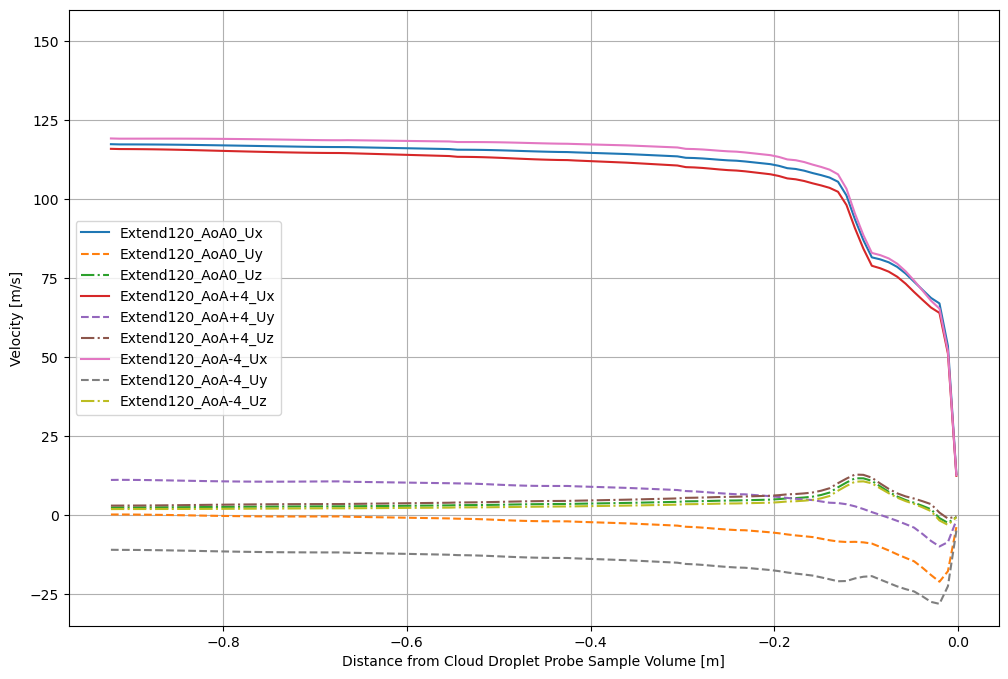

In [22]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          extend_120_line, 
          FIELD='U',
          SAVE=True)

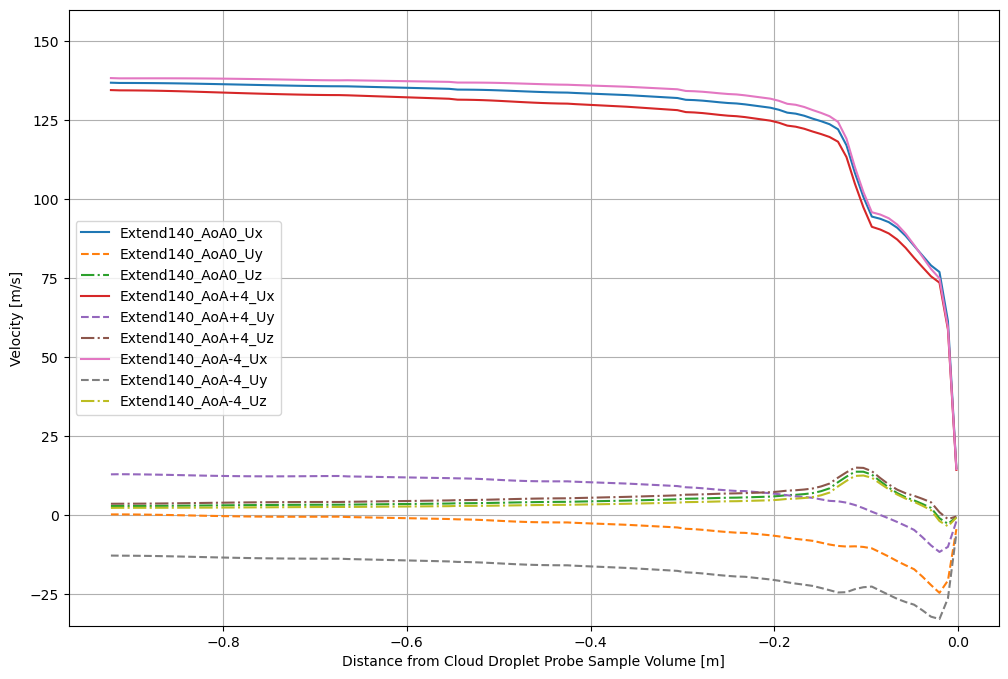

In [23]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          extend_140_line, 
          FIELD='U',
          SAVE=True)

In [24]:
navy_120_line = [case_120['navy_120_aoa0'], case_120['navy_120_aoaPos4'], case_120['navy_120_aoaNeg4']]
navy_140_line = [case_140['navy_140_aoa0'], case_140['navy_140_aoaPos4'], case_140['navy_140_aoaNeg4']]

2023-06-04 17:56:57.302 (1653.627s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:57:08.834 (1665.160s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:57:20.379 (1676.704s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


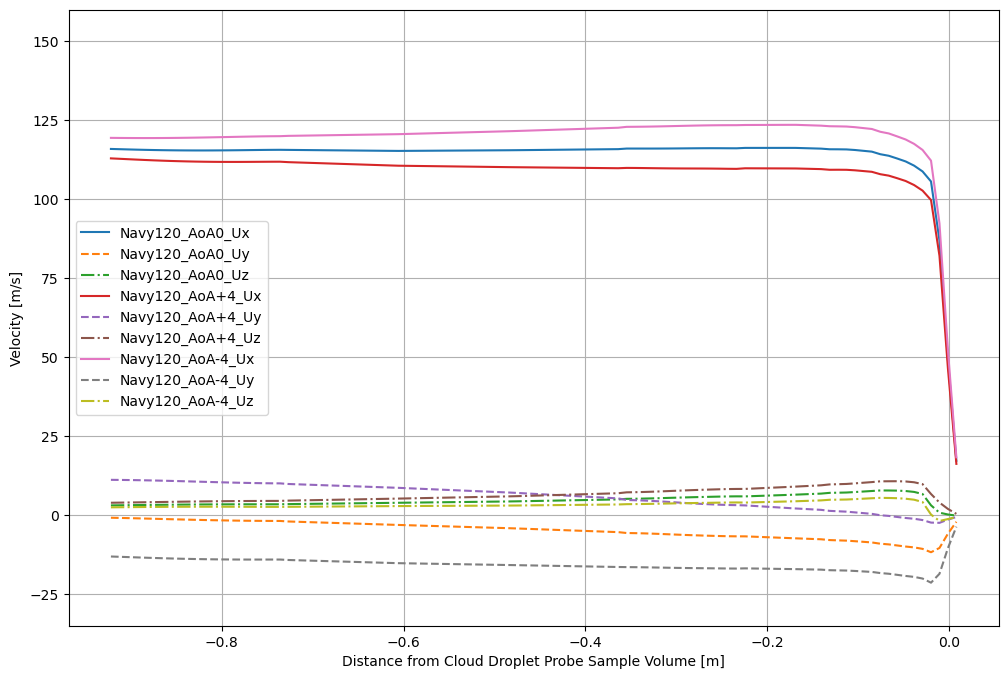

In [25]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          navy_120_line, 
          FIELD='U',
          SAVE=True)

2023-06-04 17:57:32.082 (1688.407s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:57:43.640 (1699.965s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.
2023-06-04 17:57:55.241 (1711.566s) [           2E625]      vtkPolyhedron.cxx:1742  WARN| A cell with a non-manifold triangulation has been encountered. This cell cannot be contoured.


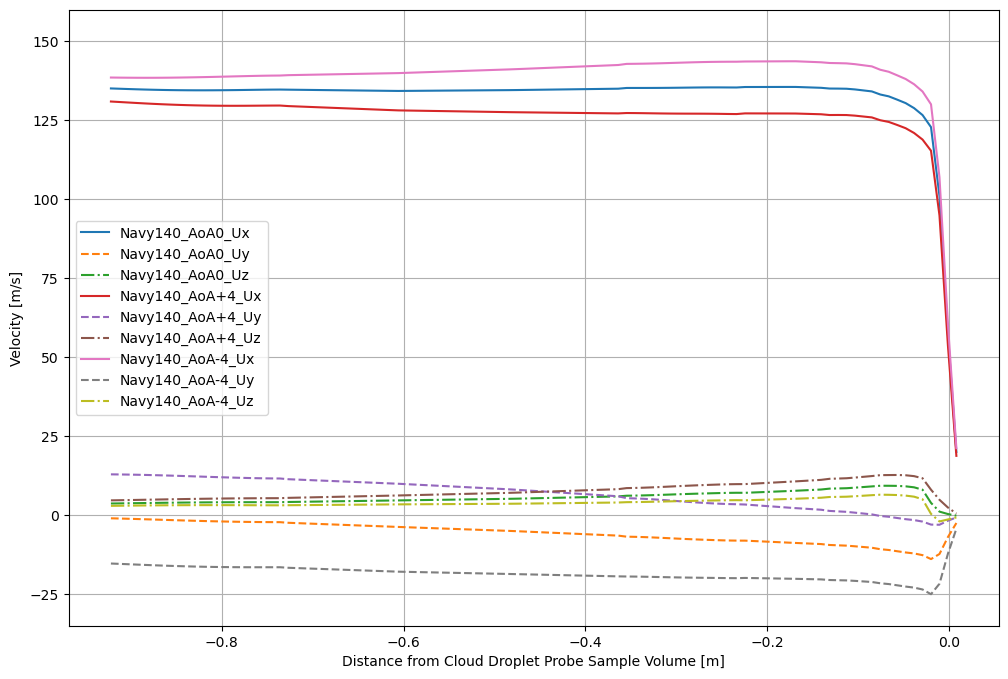

In [26]:
# Process the selected Scalar fields over the line
plot_line(solution_dir, 
          navy_140_line, 
          FIELD='U',
          SAVE=True)